# BNN on Pynq - Fashion MNIST

This notebook provides an example of a Binary Neural Network implementation on Pynq. It shows an individual example of fashion product recongition, as well as the overall accuracy of the network by processing and classifying 10,000 labelled images. The network has been trained on the Fashion MNIST dataset created by the Zalando Technology Team.

## 1. Import the BNN package

In [17]:
import bnn

## 2. Check available parameters

In [18]:
print(bnn.available_params(bnn.NETWORK_LFCW1A1))

['fashion-mnist', 'mnist', 'chars_merged']


## 3. Instantiate the classifier

In [19]:
hw_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"fashion-mnist",bnn.RUNTIME_HW)
sw_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"fashion-mnist",bnn.RUNTIME_SW)

print(hw_classifier.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 4. Load the image 

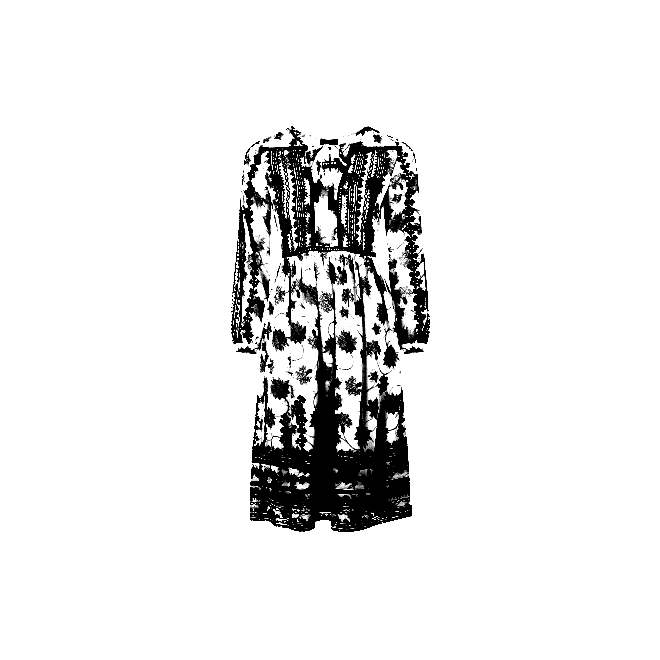

In [20]:
from PIL import Image as PIL_Image
from PIL import ImageEnhance
from PIL import ImageOps

#original image
orig_img_path = '/home/xilinx/jupyter_notebooks/bnn/pictures/pinkdress.jpg'
img = PIL_Image.open(orig_img_path).convert("L")     
                   
#Image enhancement                
contr = ImageEnhance.Contrast(img)
img = contr.enhance(3)                                              # The enhancement values (contrast and brightness) 
bright = ImageEnhance.Brightness(img)                               # depends on backgroud, external lights etc
img = bright.enhance(4.0)          

#Adding a border for future cropping
img = ImageOps.expand(img,border=80,fill='white') 
img

## 5. Crop and scale the image

In [21]:
from PIL import Image as PIL_Image
import numpy as np
import math
from scipy import misc

#Find bounding box  
inverted = ImageOps.invert(img)  
box = inverted.getbbox()  
img_new = img.crop(box)  
width, height = img_new.size  
ratio = min((28./height), (28./width))  
background = PIL_Image.new('RGB', (28,28), (255,255,255))  
if(height == width):  
    img_new = img_new.resize((28,28))  
elif(height>width):  
    img_new = img_new.resize((int(width*ratio),28))  
    background.paste(img_new, (int((28-img_new.size[0])/2),int((28-img_new.size[1])/2)))  
else:  
    img_new = img_new.resize((28, int(height*ratio)))  
    background.paste(img_new, (int((28-img_new.size[0])/2),int((28-img_new.size[1])/2)))  
  
background  
img_data=np.asarray(background)  
img_data = img_data[:,:,0]  
misc.imsave('/home/xilinx/jupyter_notebooks/img_pinkdress-mnist.png', img_data) 

## 6. Convert to BNN input format

In [22]:
from array import *
from PIL import Image as PIL_Image
from PIL import ImageOps
img_load = PIL_Image.open('/home/xilinx/jupyter_notebooks/img_pinkdress-mnist.png').convert("L")  
# Convert to BNN input format  
# The image is resized to comply with the MNIST standard. The image is resized at 28x28 pixels and the colors inverted.   
  
#Resize the image and invert it (white on black)  
smallimg = ImageOps.invert(img_load)  
smallimg = smallimg.rotate(0)  
  
data_image = array('B')  
  
pixel = smallimg.load()  
for x in range(0,28):  
    for y in range(0,28):  
        if(pixel[y,x] == 255):  
            data_image.append(255)  
        else:  
            data_image.append(1)  
          
# Setting up the header of the MNIST format file - Required as the hardware is designed for MNIST dataset         
hexval = "{0:#0{1}x}".format(1,6)  
header = array('B')  
header.extend([0,0,8,1,0,0])  
header.append(int('0x'+hexval[2:][:2],16))  
header.append(int('0x'+hexval[2:][2:],16))  
header.extend([0,0,0,28,0,0,0,28])  
header[3] = 3 # Changing MSB for image data (0x00000803)  
data_image = header + data_image  
output_file = open('/home/xilinx/jupyter_notebooks/img_pinkdress-processed', 'wb')  
data_image.tofile(output_file)  
output_file.close()   
smallimg

## 7. Launching BNN in Hardware

Inference took 23.00 microseconds
Classification rate: 43478.26 images per second
Class number: 3
Class name: Dress


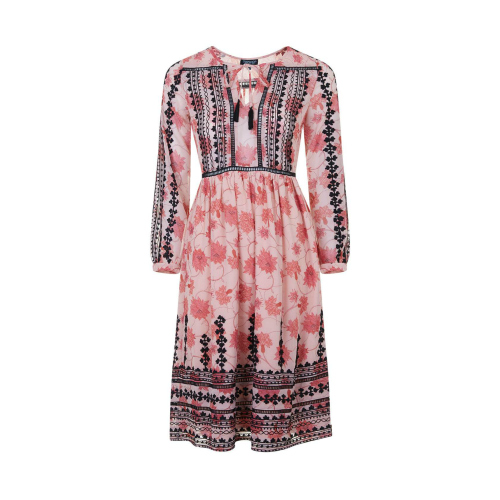

In [23]:
from IPython.display import display
from PIL import Image

class_out = hw_classifier.classify_mnist("/home/xilinx/jupyter_notebooks/img_pinkdress-processed")
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.class_name(class_out)))

path="/home/xilinx/jupyter_notebooks/bnn/pictures/pinkdress.jpg"
display(Image.open(path))

## 8. Launching BNN in Software

Inference took 79804.00 microseconds
Classification rate: 12.53 images per second
Class number: 3
Class name: Dress


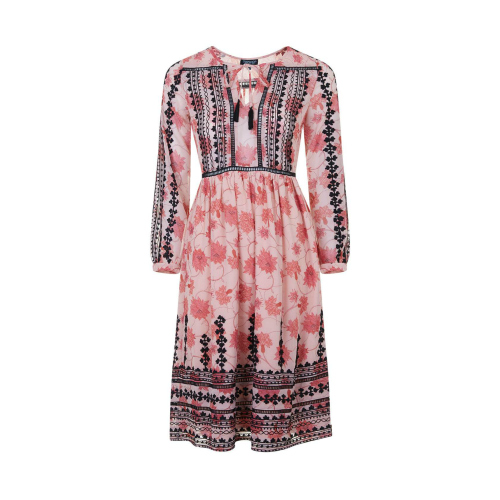

In [24]:
from IPython.display import display
from PIL import Image

class_out = sw_classifier.classify_mnist("/home/xilinx/jupyter_notebooks/img_pinkdress-processed")
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.class_name(class_out)))

path="/home/xilinx/jupyter_notebooks/bnn/pictures/pinkdress.jpg"
display(Image.open(path))

## 9. Download and save test images and labels

In [9]:
#get
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz; 
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz; 
    
#unzip    
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz

#read labels
labels = []
with open("/home/xilinx/jupyter_notebooks/bnn/t10k-labels-idx1-ubyte","rb") as lbl_file:
    #read magic number and number of labels (MSB first) -> MNIST header
    magicNum = int.from_bytes(lbl_file.read(4), byteorder="big")
    countLbl = int.from_bytes(lbl_file.read(4), byteorder="big")
    #now the labels are following byte-wise
    for idx in range(countLbl):
        labels.append(int.from_bytes(lbl_file.read(1), byteorder="big"))
    lbl_file.close()
len(labels)

--2019-08-26 19:30:10--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.23
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422102 (4.2M) [binary/octet-stream]
Saving to: ‘t10k-images-idx3-ubyte.gz’

t10k-images-idx3-ub 100%[===================>]   4.22M  1.89MB/s    in 2.2s    

2019-08-26 19:30:18 (1.89 MB/s) - ‘t10k-images-idx3-ubyte.gz’ saved [4422102/4422102]

--2019-08-26 19:30:18--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.23
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com

10000

## 10. Hardware Inference

In [10]:
lfcW1A1_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"fashion-mnist",bnn.RUNTIME_HW)
lfcW1A1_classifier.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
result_W1A1 = lfcW1A1_classifier.classify_mnists("/home/xilinx/jupyter_notebooks/bnn/t10k-images-idx3-ubyte")

Inference took 84121.00 microseconds, 8.41 usec per image
Classification rate: 118876.38 images per second


## 11. Software Inference

In [12]:
sw_lfcW1A1_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"fashion-mnist",bnn.RUNTIME_SW)
sw_lfcW1A1_classifier.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [13]:
sw_resultW1A1 = sw_lfcW1A1_classifier.classify_mnists("/home/xilinx/jupyter_notebooks/bnn/t10k-images-idx3-ubyte")

Inference took 789958750.00 microseconds, 78995.88 usec per image
Classification rate: 12.66 images per second


## 12. Calculate overall accuracy of network on Hardware

In [25]:
#compare against labels
countRight = 0
for idx in range(len(labels)):
    if labels[idx] == result_W1A1[idx]:
        countRight += 1
accuracyW1A1 = countRight*100/len(labels)

print("Hardware Accuracy Fashion MNIST: ", accuracyW1A1)

Hardware Accuracy Fashion MNIST:  84.81


## 13. Calculate overall accuracy of network on Software

In [26]:
#compare against labels
countRight = 0
for idx in range(len(labels)):
    if labels[idx] == sw_resultW1A1[idx]:
        countRight += 1
accuracyW1A1 = countRight*100/len(labels)

print("Software Accuracy Fashion MNIST: ", accuracyW1A1)

Software Accuracy Fashion MNIST:  84.81


## 15. Reset the device

In [27]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()